In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_08 import *

# Imagenette data

In [3]:
path = untar_data(URLs.IMAGENETTE_160)

In [4]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 128

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [5]:
nfs = [32,64,128,256]

In [6]:
cbfs = [CudaCallback, Recorder,
       partial(AvgStatsCallback, accuracy),
       partial(BatchTransformXCallback, norm_imagenette)]

In [7]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbfs)

In [8]:
run.fit(1, learn)

train: [1.8230370567773788, tensor(0.3708, device='cuda:0')]
valid: [2.416976761544586, tensor(0.2910, device='cuda:0')]


# Refining the optimizer

In [22]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.param_groups = list(params)
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for _ in self.param_groups]
        self.steppers = listify(steppers)
        
    def grad_params(self):
        return [(p, hyper) for pg, hyper in zip(self.param_groups, self.hypers) for p in pg if p.grad is not None]
    
    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
            
    def step(self): 
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [23]:
#export
def sgd_step(p, lr, **kwargs):
    p.data.add_(p.grad.data, alpha=-lr)
    return p

In [24]:
opt_func = partial(Optimizer, steppers=[sgd_step])

In [37]:
#export
class Recorder(Callback):
    def begin_fit(self):
        self.lrs, self.losses = [], []
        
    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        losses = [p.item() for p in self.losses]
        n = len(losses) - skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])

In [38]:
#export
class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_funcs):
        self.pname, self.sched_funcs = pname, listify(sched_funcs)
        
    def begin_batch(self):
        if not self.in_train: return
        fs = self.sched_funcs
        if len(fs) == 1: fs = fs * len(self.opt.param_groups)
        pos = self.n_epochs / self.epochs
        for f,h in zip(fs, self.opt.hypers): h[self.pname] = f(pos)

In [39]:
#export
class LR_Find(Callback):
    _order = 1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter, self.min_lr, self.max_lr = max_iter, min_lr, max_lr
        self.best_loss = 1e9
        
    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter / self.max_iter
        lr = self.min_lr * (self.max_lr / self.min_lr) ** pos
        for pg in self.opt.hypers: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter >= self.max_iter or self.loss > self.best_loss * 10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [28]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3,0.6), sched_cos(0.6,0.2)])

In [32]:
cbfs = [partial(AvgStatsCallback, accuracy),
       CudaCallback, Recorder,
       partial(ParamScheduler, 'lr', sched)]

In [33]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbfs, opt_func)

In [34]:
%time run.fit(1, learn)

train: [1.8587809562783821, tensor(0.3584, device='cuda:0')]
valid: [1.5111499800955415, tensor(0.4864, device='cuda:0')]
CPU times: user 4.81 s, sys: 2.94 s, total: 7.75 s
Wall time: 9.19 s


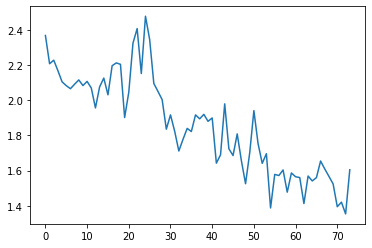

In [36]:
run.recorder.plot_loss()

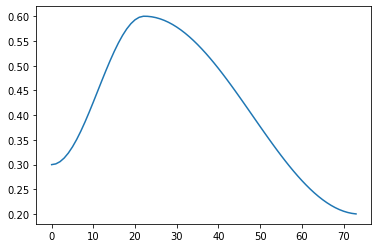

In [40]:
run.recorder.plot_lr()

In [41]:
cbfs = [partial(AvgStatsCallback, accuracy),
       CudaCallback, Recorder,
       LR_Find]

In [42]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbfs, opt_func)

In [43]:
%time run.fit(1, learn)

train: [2.296849010587179, tensor(0.1359, device='cuda:0')]
valid: [2.1428970939490446, tensor(0.2331, device='cuda:0')]
CPU times: user 4.9 s, sys: 2.79 s, total: 7.68 s
Wall time: 8.93 s


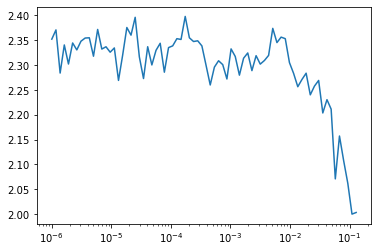

In [44]:
run.recorder.plot()

# Weight decay

In [49]:
sgd_step??

Signature: sgd_step(p, lr, **kwargs)
Docstring: <no docstring>
Source:   
def sgd_step(p, lr, **kwargs):
    p.data.add_(p.grad.data, alpha=-lr)
    return p
File:      /tmp/ipykernel_7053/2496638283.py
Type:      function


In [45]:
#export
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1 - lr*wd)
#     p.data.add_(p.data, alpha=lr*wd) # why not like this? -> decoupled weight regularization paper
    return p
weight_decay._defaults = dict(wd=0.)

In [46]:
#export
def l2_reg(p, lr, wd, **kwargs):
    p.grad.data.add_(p.data, alpha=wd)
    return p
l2_reg._defaults = dict(wd=0.)

In [47]:
#export
def maybe_update(os, dic, f):
    for o in os:
        for k,v in f(o).items():
            if k not in dic: dic[k] = v
                
def get_defaults(dic): return getattr(dic, '_defaults', {})

In [71]:
#export
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        
        self.param_groups = list(params)
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for _ in self.param_groups]
        
    def grad_params(self):
        return [(p,hyper) for pg, hyper in zip(self.param_groups, self.hypers) for p in pg if p.grad is not None]
    
    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
            
    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [72]:
#export
sgd_opt = partial(Optimizer, steppers=[sgd_step, weight_decay])

In [73]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbfs, sgd_opt)

In [74]:
model = learn.model

In [75]:
opt = sgd_opt(model.parameters(), lr=0.1)
test_eq(opt.hypers[0]['wd'], 0.)
test_eq(opt.hypers[0]['lr'], 0.1)

In [76]:
opt = sgd_opt(model.parameters(), lr=0.2, wd=1e-4)
test_eq(opt.hypers[0]['wd'], 1e-4)
test_eq(opt.hypers[0]['lr'], 0.2)

In [77]:
cbfs = [partial(AvgStatsCallback, accuracy), CudaCallback]

In [78]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbfs, partial(sgd_opt, wd=0.01))

In [79]:
run.fit(1, learn)

train: [1.7931665583086915, tensor(0.3800, device='cuda:0')]
valid: [2.472415654856688, tensor(0.2701, device='cuda:0')]


# With momentum

In [125]:
#export
class StatefulOptimizer(Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults):
        self.stats = listify(stats)
        maybe_update(self.stats, defaults, get_defaults)
        super().__init__(params, steppers, **defaults)
        self.state = {}
        
    def step(self):
        for p,hyper in self.grad_params():
            if p not in self.state:
                self.state[p] = {}
                maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
            state = self.state[p]
            for stat in self.stats: state = stat.update(p, state, **hyper)
            compose(p, self.steppers, **state, **hyper)
            self.state[p] = state

In [126]:
#export
class Stat():
    _defaults = {}
    def init_state(self, p): raise NotImplementedError
    def update(self, p, state, **kwargs): raise NotImplementedError

In [127]:
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    
    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(p.grad.data)
        return state

In [128]:
#export
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(grad_avg, alpha=-lr)
    return p

In [129]:
sgd_mom_opt = partial(StatefulOptimizers, steppers=[momentum_step, sgd_step], stats=[AverageGrad()], wd=0.01)

In [130]:
learn,run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=sgd_mom_opt)

In [131]:
run.fit(1, learn)

train: [2.169498206317985, tensor(0.3099, device='cuda:0')]
valid: [1.7634848974920383, tensor(0.4003, device='cuda:0')]


# Momentum experiments

In [132]:
x = torch.linspace(-4, 4, 200)
y = torch.randn(200) + 0.3
betas = [0.5, 0.7, 0.9, 0.99]

In [133]:
def plot_mom(f):
    _, axes = plt.subplots(2,2, figsize=(12,8))
    for beta, ax in zip(betas, axes.flatten()):
        ax.plot(y, linestyle='None', marker='.')
        avg, res = None, []
        for i, yi in enumerate(y):
            avg, p = f(beta, avg, i, yi)
            res.append(p)
        ax.plot(res, color='red')
        ax.set_title(f'beta: {beta}')

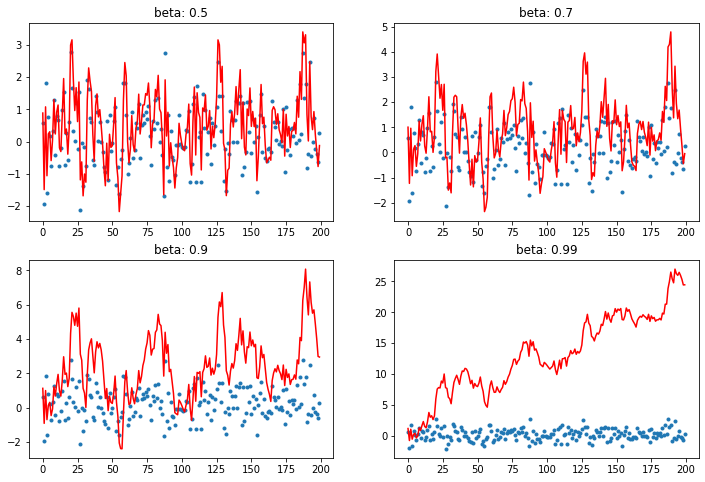

In [134]:
def mom1(beta, avg, i, yi):
    if avg is None: avg = yi
    res = avg * beta + yi
    return res, res
plot_mom(mom1)

In [135]:
#export
def lin_comb(v1, v2, beta): return v1 * beta + (1 - beta) * v2

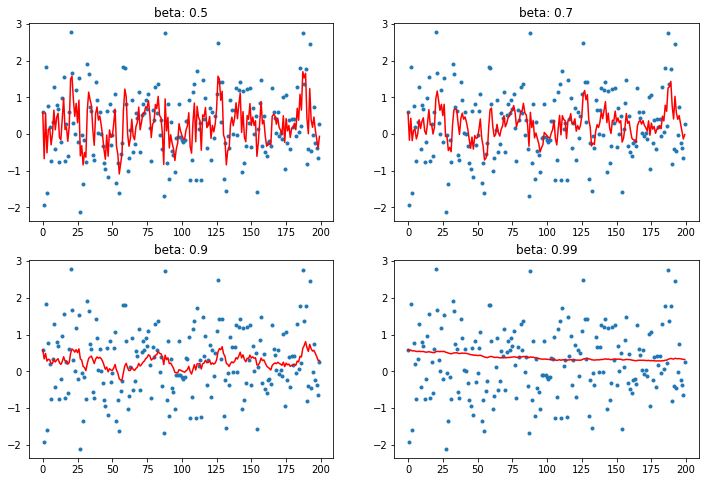

In [136]:
def mom2(beta, avg, i, yi):
    if avg is None: avg = yi
    res = lin_comb(avg, yi, beta)
    return res, res
plot_mom(mom2)

In [137]:
y = 1 - (x/3) ** 2 + torch.randn(200) * 0.1

In [138]:
y[0] = 0.5

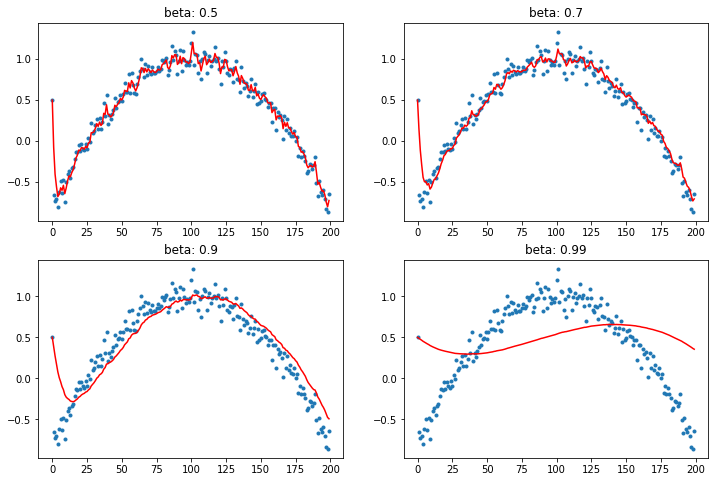

In [139]:
plot_mom(mom2)

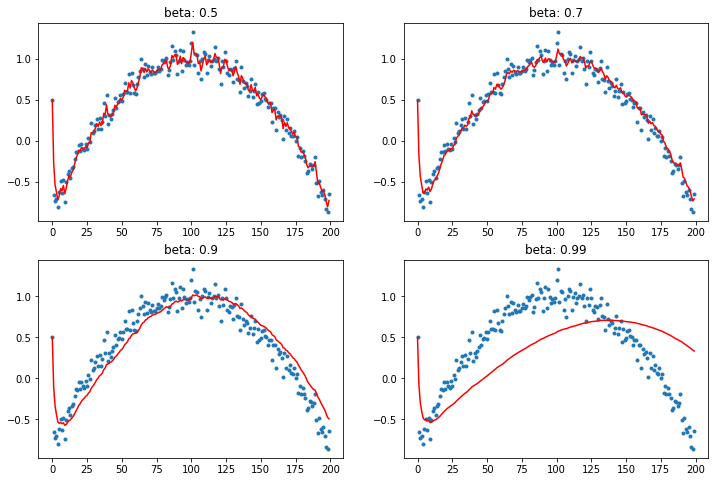

In [140]:
def mom3(beta, avg, i, yi):
    if avg is None: avg = 0
    avg = lin_comb(avg, yi, beta)
    return avg, avg / (1 - beta**(i+1))
plot_mom(mom3)

# Adam and friends

In [141]:
#export
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    
    def __init__(self, dampening:bool=False): self.dampening = dampening
    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['mom_damp'] = 1 - mom if self.dampening else 1
        state['grad_avg'].mul_(mom).add_(p.grad.data, alpha=state['mom_damp'])
        return state

In [151]:
#export
class AverageSqrGrad(Stat):
    _defaults = dict(sqr_mom=0.99)
    
    def __init__(self, dampening:bool=False): self.dampening = dampening
    def init_state(self, p): return {'sqr_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, sqr_mom, **kwargs):
        state['sqr_damp'] = 1 - sqr_mom if self.dampening else 1
        state['sqr_avg'].mul_(sqr_mom).addcmul_(p.grad.data, p.grad.data, value=state['sqr_damp'])
        return state

In [152]:
#export
class StepCount(Stat):
    def init_state(self, p): return {'step': 0}
    def update(self, p, state, **kwargs):
        state['step'] += 1
        return state

In [153]:
#export
def debias(mom, damp, step): return damp * (1 - mom**step) / (1 - mom)

In [167]:
#export
def adam_step(p, lr, mom, mom_damp, grad_avg, sqr_mom, sqr_damp, sqr_avg, step, eps, **kwargs):
    debias1 = debias(mom, mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
#     p.data.addcdiv_(grad_avg, (sqr_avg / debias2).sqrt(), value=-lr / debias1)
    p.data.addcdiv_(-lr/debias1, grad_avg, (sqr_avg/debias2).sqrt())
    return p
adam_step._defaults = dict(eps=1e-5)

In [168]:
#export
def adam_opt(xtra_step=None, **kwargs):
    return partial(StatefulOptimizer, steppers=[adam_step, weight_decay] + listify(xtra_step),
                   stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()], **kwargs)

In [169]:
learn, run = get_learn_run(nfs, data, 0.001, conv_layer, cbfs, adam_opt())

In [170]:
run.fit(3, learn)

train: [1.7229922559800401, tensor(0.4045, device='cuda:0')]
valid: [1.4658616142515923, tensor(0.5126, device='cuda:0')]
train: [1.206808999267346, tensor(0.6071, device='cuda:0')]
valid: [1.3022059116242037, tensor(0.5682, device='cuda:0')]
train: [0.879820417282712, tensor(0.7257, device='cuda:0')]
valid: [1.299876094745223, tensor(0.5732, device='cuda:0')]


# LAMB

In [171]:
def lamb_step(p, lr, mom, mom_damp, grad_avg, sqr_mom, sqr_damp, sqr_avg, step, eps, wd, **kwargs):
    debias1 = debias(mom, mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    r1 = p.data.pow(2).mean().sqrt()
    step = (grad_avg / debias1) / ((sqr_avg / debias2).sqrt() + eps) + wd * p.data
    r2 = step.pow(2).mean().sqrt()
    p.data.add_(-lr * min(r1/r2, 10), step)
    return p
lamb_step._defaults = dict(eps=1e-6, wd=0.)

In [172]:
lamb = partial(StatefulOptimizer, steppers=[lamb_step], stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()])

In [173]:
learn, run = get_learn_run(nfs, data, 0.003, conv_layer, cbfs, lamb)

In [174]:
run.fit(3, learn)

train: [1.867831047365086, tensor(0.3451, device='cuda:0')]
valid: [1.8041717257165606, tensor(0.3975, device='cuda:0')]
train: [1.3846448567364558, tensor(0.5401, device='cuda:0')]
valid: [1.537330438893312, tensor(0.4953, device='cuda:0')]
train: [1.105017029253353, tensor(0.6406, device='cuda:0')]
valid: [1.4051518958996816, tensor(0.5422, device='cuda:0')]
